In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Bidirectional
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model


with open("/content/drive/MyDrive/NLP_Project/sonnets.txt") as corpus_file:
    corpus = corpus_file.read()
print("Loaded a corpus of {0} characters".format(len(corpus)))

Loaded a corpus of 94652 characters


In [ ]:
# Get a unique identifier for each char in the corpus, then make some dicts to ease encoding and decoding
chars = sorted(list(set(corpus)))
num_chars = len(chars)
encoding = {c: i for i, c in enumerate(chars)}
decoding = {i: c for i, c in enumerate(chars)}
print("Our corpus contains {0} unique characters.".format(num_chars))

Our corpus contains 62 unique characters.


#Splitting our corpus into X and y. 
##50 characters are added to X, 51st character is added to y.


In [ ]:
# it slices, it dices, it makes julienned datasets!
# chop up our data into X and y, slice into roughly (num_chars / skip) overlapping 'sentences'
# of length sentence_length, and encode the chars
sentence_length = 50
skip = 1
X_data = []
y_data = []
for i in range (0, len(corpus) - sentence_length, skip):
    sentence = corpus[i:i + sentence_length]
    next_char = corpus[i + sentence_length]
    X_data.append([encoding[char] for char in sentence])
    y_data.append(encoding[next_char])

num_sentences = len(X_data)
print("Sliced our corpus into {0} sentences of length {1}".format(num_sentences, sentence_length))

Sliced our corpus into 94602 sentences of length 50


#Vectorizing the data

In [ ]:
# Vectorize our data and labels. We want everything in one-hot
# because smart data encoding cultivates phronesis and virtue.
print("Vectorizing X and y...")
X = np.zeros((num_sentences, sentence_length, num_chars), dtype=np.bool)
y = np.zeros((num_sentences, num_chars), dtype=np.bool)
for i, sentence in enumerate(X_data):
    for t, encoded_char in enumerate(sentence):
        X[i, t, encoded_char] = 1
    y[i, y_data[i]] = 1

# Double check our vectorized data before we sink hours into fitting a model
print("Sanity check y. Dimension: {0} # Sentences: {1} Characters in corpus: {2}".format(y.shape, num_sentences, len(chars)))
print("Sanity check X. Dimension: {0} Sentence length: {1}".format(X.shape, sentence_length))

Vectorizing X and y...
Sanity check y. Dimension: (94602, 62) # Sentences: 94602 Characters in corpus: 62
Sanity check X. Dimension: (94602, 50, 62) Sentence length: 50


#Model definition
We have used recurrent dropout function which prevents overfitting

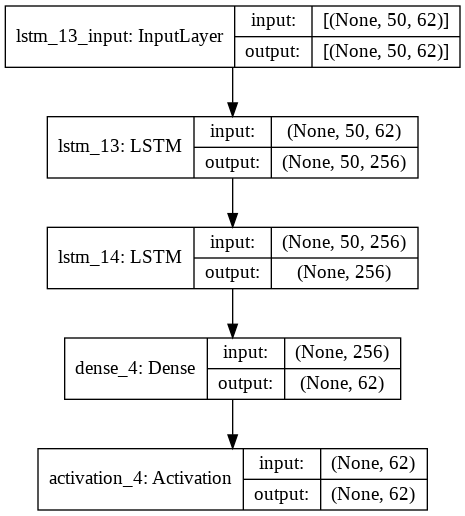

In [ ]:
# Define our model
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(sentence_length, num_chars), recurrent_dropout=0.15))
model.add(LSTM(256))
model.add(Dense(num_chars))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#Fitting the model

In [ ]:

# Dump our model architecture to a file so we can load it elsewhere
architecture = model.to_yaml()
with open('model.yaml', 'a') as model_file:
    model_file.write(architecture)

# Set up checkpoints
file_path="weights-{epoch:02d}-{loss:.3f}.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor="loss", verbose=1, save_best_only=True, mode="min")
callbacks = [checkpoint]

# Action time! [Insert guitar solo here]
model.fit(X, y, epochs=30, batch_size=128, callbacks=callbacks)

Epoch 1/30
740/740 [==============================] - 175s 232ms/step - loss: 2.9665

Epoch 00001: loss improved from inf to 2.62260, saving model to weights-01-2.623.hdf5
Epoch 2/30
740/740 [==============================] - 173s 233ms/step - loss: 2.0782

Epoch 00002: loss improved from 2.62260 to 2.01183, saving model to weights-02-2.012.hdf5
Epoch 3/30
740/740 [==============================] - 170s 230ms/step - loss: 1.8655

Epoch 00003: loss improved from 2.01183 to 1.83440, saving model to weights-03-1.834.hdf5
Epoch 4/30
740/740 [==============================] - 169s 229ms/step - loss: 1.7431

Epoch 00004: loss improved from 1.83440 to 1.72741, saving model to weights-04-1.727.hdf5
Epoch 5/30
740/740 [==============================] - 167s 226ms/step - loss: 1.6631

Epoch 00005: loss improved from 1.72741 to 1.64758, saving model to weights-05-1.648.hdf5
Epoch 6/30
740/740 [==============================] - 168s 228ms/step - loss: 1.5860

Epoch 00006: loss improved from 1.6475

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 50, 256)           326656    
_________________________________________________________________
lstm_14 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_4 (Dense)              (None, 62)                15934     
_________________________________________________________________
activation_4 (Activation)    (None, 62)                0         
Total params: 867,902
Trainable params: 867,902
Non-trainable params: 0
_________________________________________________________________


# Testing our model

In [ ]:
import numpy as np
from keras.models import model_from_yaml
from random import randint


class GenerativeNetwork:
    def __init__(self, corpus_path, model_path, weights_path):
        with open(corpus_path) as corpus_file:
            self.corpus = corpus_file.read()

        # Get a unique identifier for each char in the corpus,
        # then make some dicts to ease encoding and decoding
        self.chars = sorted(list(set(self.corpus)))
        self.encoding = {c: i for i, c in enumerate(self.chars)}
        self.decoding = {i: c for i, c in enumerate(self.chars)}

        # Some fields we'll need later
        self.num_chars = len(self.chars)
        self.sentence_length = 50
        self.corpus_length = len(self.corpus)

        # Build our network from loaded architecture and weights
        with open(model_path) as model_file:
            architecture = model_file.read()

        self.model = model_from_yaml(architecture)
        self.model.load_weights(weights_path)
        self.model.compile(loss='categorical_crossentropy', optimizer='adam')

    def generate(self, seed_pattern):
        X = np.zeros((1, self.sentence_length, self.num_chars), dtype=np.bool)
        for i, character in enumerate(seed_pattern):
            X[0, i, self.encoding[character]] = 1

        generated_text = ""
        for i in range(500):
            prediction = np.argmax(self.model.predict(X, verbose=0))

            generated_text += self.decoding[prediction]

            activations = np.zeros((1, 1, self.num_chars), dtype=np.bool)
            activations[0, 0, prediction] = 1
            X = np.concatenate((X[:, 1:, :], activations), axis=1)

        return generated_text

    def make_seed(self, seed_phrase=""):
            if seed_phrase:
                phrase_length = len(seed_phrase)
                pattern = ""
                for i in range(0, self.sentence_length):
                    pattern += seed_phrase[i % phrase_length]
            else:
                seed = randint(0, self.corpus_length - self.sentence_length)
                pattern = self.corpus[seed:seed + self.sentence_length]

            return pattern

corpus_path='/content/drive/MyDrive/NLP_Project/sonnets.txt'
model_path='/content/drive/MyDrive/NLP_Project/model.yaml'
weights_path='/content/drive/MyDrive/NLP_Project/weights-30-0.772.hdf5'

lstm_model=GenerativeNetwork(corpus_path,model_path,weights_path)

pat=lstm_model.make_seed("Since that my life on thy revolt doth lie.")
new_poem=lstm_model.generate(pat)

print(new_poem)


ought,
That thou art for memorian throughts or mend.
Therefore is this, and this to me behold,
That thou dost live your self in you doth grow,
  And therefore have I slept in thee I say,
'Truth needs the world will be the world's face survey,
If thou this senstard to the summer art,
Within the lovely graves where thou dost steel
But then my love in thy advantage me,
The old of more that live in other place.

O! how thy offers, seeing this, I see doth wrongs.
  Then that your love with thee all b
